In [ ]:
import pandas as pd
import numpy as np
import re
import string
import random
import missingno
import plotly.express as px
import joblib

# plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


# Download necessary resources for NLP
from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize

# Oversample and plot imbalanced dataset with SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# fine-tuning, ensemble
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_raw = pd.read_csv('/kaggle/fake_job_postings.csv')
data = data_raw.copy()

In [ ]:
def split(location):
    return str(location).split(',')[0]

data['country'] = data.location.apply(split)

# only train and test job postings in US
data = data.loc[data['country']=='US'].copy()

In [ ]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

data.fillna(' ', inplace=True)

data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']

In [ ]:
data['fraudulent'].value_counts()

fraudulent
0    9926
1     730
Name: count, dtype: int64

In [ ]:
data.drop_duplicates(subset='text', inplace=True)

In [ ]:
data['fraudulent'].value_counts()

fraudulent
0    9685
1     718
Name: count, dtype: int64

In [ ]:
data = data.reset_index()

In [ ]:
# split train and test dataset
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data.fraudulent):
  train_temp = data.iloc[train_index]
  X_test = data.iloc[test_index]['text']
  y_test = data.iloc[test_index]['fraudulent']

for train_index, val_index in split.split(train_temp, train_temp.fraudulent):
  X_train = train_temp.iloc[train_index]['text']
  y_train = train_temp.iloc[train_index]['fraudulent']
  X_val = train_temp.iloc[val_index]['text']
  y_val = train_temp.iloc[val_index]['fraudulent']

In [ ]:
# pip install googletrans==4.0.0-rc1

In [ ]:
# from googletrans import Translator
# from time import sleep

# def back_translation(text, src_lang='en', intermediate_lang=None):
#     # Create a translator object
#     translator = Translator()

#     # If no intermediate language is provided, randomly choose one
#     if intermediate_lang is None:
#         intermediate_langs = ['fr', 'es', 'de', 'ru']#, 'zh-cn']  # List of example languages
#         intermediate_lang = random.choice(intermediate_langs)

#     # Translate to intermediate language
#     intermediate_text = translator.translate(text, src=src_lang, dest=intermediate_lang).text
#     if not intermediate_text:
#         print(text)
#     # Translate back to source language
#     augmented_text = translator.translate(intermediate_text, src=intermediate_lang, dest=src_lang).text

#     return augmented_text

# def augment_dataset(X_train, y_train):
#     augmented_dataset = []
#     X_train_fake = X_train[y_train == 1].reset_index(drop = True)
#     i = 0
#     for fake in X_train_fake:
#         i += 1
#         print(i, len(fake))
#         if len(fake) < 5000:
#             augmented_text = back_translation(fake) #, intermediate_lang='es')
#             sleep(10)
#             augmented_dataset.append(augmented_text)
#         if i%10 == 0:
#             sleep(30)
#     dataset = pd.Series(augmented_dataset)
#     dataset.to_csv('augment_data.csv', index=False)
#     return pd.concat([X_train, dataset]) #, pd.concat([y_train, np.ones(len(augmented_dataset))])

In [ ]:
# X_train_new = augment_dataset(X_train, y_train)

In [ ]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm') #, disable=['parser', 'tagger', 'ner'])

# Custom tokenizer using spaCy
def spacy_tokenizer(document):
    result = []
    for sent in sent_tokenize(document):
        for token in nlp(sent):
            if not token.is_punct and not token.is_space and not token.is_stop:
                if not token.like_num and not token.like_url:
                    if len(token.text) < 30:
                        result.append(token.lemma_)
    return result


In [ ]:
# creating our bag of words
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer,
                               lowercase=True,
                               max_df=0.5,
                               min_df=2,
                               ngram_range=(1, 2)
                               )


# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # remove any symbols
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    # Removing spaces and converting text into lowercase
    return text.strip().lower()


In [ ]:
data_pipeline =  Pipeline([("cleaner", predictors()),
                           ('vectorizer', tfidf_vector),
                           ("selector", SelectPercentile(chi2, percentile=10)),
                          ])

In [ ]:
data_pipeline

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7a098a91f400>),
                ('vectorizer',
                 TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7a0989969fc0>)),
                ('selector',
                 SelectPercentile(score_func=<function chi2 at 0x7a09c5401ea0>))])

In [ ]:
X_train_p = data_pipeline.fit_transform(X_train, y_train)
X_val_p = data_pipeline.transform(X_val)
X_test_p = data_pipeline.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train_p.shape

(6657, 17897)

In [ ]:
def plot_precision_recall_f1_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    f1 = 2 * (precisions * recalls) / (precisions + recalls)
    plt.plot(thresholds, f1[:-1], "k:", label="F1_Score", linewidth=2)
    plt.legend(loc="center right", fontsize=12)
    plt.xlabel("Threshold", fontsize=12)
    plt.grid(True)

In [ ]:
def models(x, X_train, X_val, X_test, y_train, y_val, y_test):
  if x == 'LogisticRegression':
    clf = LogisticRegression(class_weight='balanced', random_state = 42, max_iter = 200, n_jobs = -1)

  elif x == 'RandomForest':
    clf = RandomForestClassifier(random_state = 42, n_jobs = -1,
                                 n_estimators = 800,
                                )

  elif x == 'XGBoost':
    clf = XGBClassifier(random_state = 42, n_jobs = -1,
                        early_stopping_rounds = 10,  # Stop if the validation metric doesn't improve for 10 rounds
                        eval_metric='auc',  # Use area under the ROC curve as the evaluation metric
                        gamma = 0.01
                        )

  else:
    print("wrong input")
    exit()

  pipe = clf

  # Fitting model
  if x == 'XGBoost':
    pipe.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],  # Validation data
    verbose=False
    )
  else:
    pipe.fit(X_train, y_train)

#   filename = x + '.joblib'
#   joblib.dump(pipe, filename)

  # Predicting with a test dataset
  y_train_pred = pipe.predict(X_train)
  y_val_pred = pipe.predict(X_val)
  y_test_pred = pipe.predict(X_test)

  # Model Report
  print(x, 'train classification_report: \n', classification_report(y_train, y_train_pred))
  print(x, 'valid classification_report: \n', classification_report(y_val, y_val_pred))
  print(x, 'test classification_report: \n', classification_report(y_test, y_test_pred))

  print(x, 'train confusion_matrix: \n', confusion_matrix(y_train, y_train_pred))
  print(x, 'valid confusion_matrix: \n', confusion_matrix(y_val, y_val_pred))
  print(x, 'test confusion_matrix: \n', confusion_matrix(y_test, y_test_pred))

  sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap='Blues', fmt='g')
  plt.title('Confusion Matrix for training dataset')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, cmap='Blues', fmt='g')
  plt.title('Confusion Matrix for validation dataset')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap='Blues', fmt='g')
  plt.title('Confusion Matrix for test dataset')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  y_train_proba = pipe.predict_proba(X_train)
  y_val_proba = pipe.predict_proba(X_val)
  y_test_proba = pipe.predict_proba(X_test)

  print('train roc_auc_score: {0:.3f}'.format(roc_auc_score(y_train, y_train_proba[:,1])))
  print('valid roc_auc_score: {0:.3f}'.format(roc_auc_score(y_val, y_val_proba[:,1])))
  print('test roc_auc_score: {0:.3f}'.format(roc_auc_score(y_test, y_test_proba[:,1])))

  print('train pr_auc_score: {0:.3f}'.format(average_precision_score(y_train, y_train_proba[:,1])))
  print('valid pr_auc_score: {0:.3f}'.format(average_precision_score(y_val, y_val_proba[:,1])))
  print('test pr_auc_score: {0:.3f}'.format(average_precision_score(y_test, y_test_proba[:,1])))


# draw plot to determine threshold influence
  precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba[:,1])
  plt.figure(figsize=(8, 4))
  plot_precision_recall_f1_vs_threshold(precisions, recalls, thresholds)

  return pipe

In [ ]:
# model_lr = models('LogisticRegression',X_train_p, X_val_p, X_test_p, y_train, y_val, y_test)

In [ ]:
# model_rf = models('RandomForest',X_train_p, X_val_p, X_test_p, y_train, y_val, y_test)

In [ ]:
# model_xgb = models('XGBoost',X_train_p, X_val_p, X_test_p, y_train, y_val, y_test)

RandomForest train classification_report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6198
           1       1.00      1.00      1.00       459

    accuracy                           1.00      6657
   macro avg       1.00      1.00      1.00      6657
weighted avg       1.00      1.00      1.00      6657

RandomForest valid classification_report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1550
           1       1.00      0.73      0.84       115

    accuracy                           0.98      1665
   macro avg       0.99      0.87      0.92      1665
weighted avg       0.98      0.98      0.98      1665

RandomForest test classification_report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1937
           1       0.97      0.77      0.86       144

    accuracy                           0.98      20

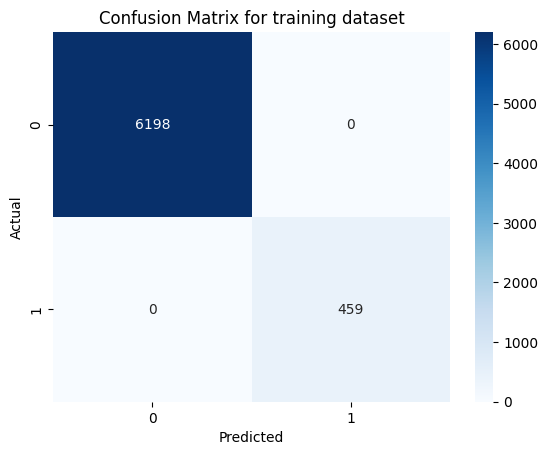

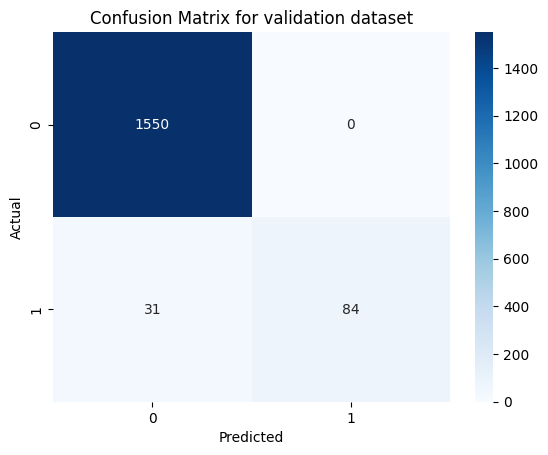

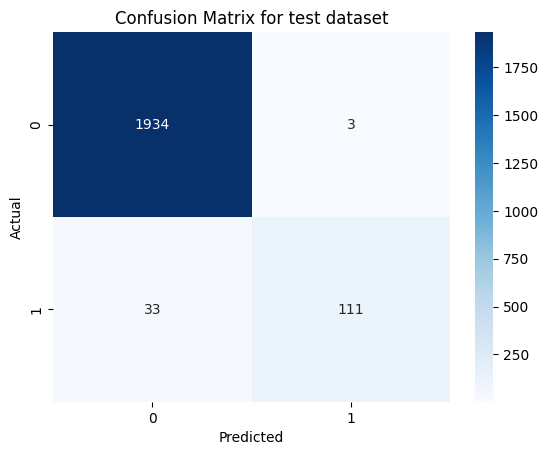

train roc_auc_score: 1.000
valid roc_auc_score: 0.986
test roc_auc_score: 0.984
train pr_auc_score: 1.000
valid pr_auc_score: 0.942
test pr_auc_score: 0.936


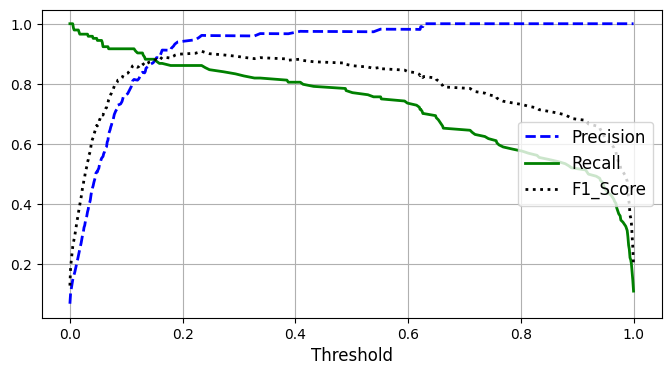

In [ ]:
columns_names = list(data_pipeline.named_steps["selector"].get_feature_names_out(data_pipeline.named_steps["vectorizer"].get_feature_names_out()))
df_train = pd.DataFrame(X_train_p.todense(), columns=columns_names)
df_val = pd.DataFrame(X_val_p.todense(), columns=columns_names)
df_test = pd.DataFrame(X_test_p.todense(), columns=columns_names)
model_rf = models('RandomForest',df_train, df_val, df_test, y_train, y_val, y_test)

In [ ]:
# def fine_tune_model(model, param_grid, X_train, y_train):
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     grid_search = RandomizedSearchCV(model, param_grid, cv=skf, n_iter = 15,
#                               scoring='average_precision',
#                               return_train_score=True,
#                               n_jobs = -1)
#     grid_search.fit(X_train, y_train)
#     print("best parameters: ", grid_search.best_params_)
#     print("best score: ", grid_search.best_score_)

#     cvres = grid_search.cv_results_
# #     for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
# #         print((-mean_score), params)

#     return cvres

In [ ]:
# params = {
# #           'n_estimators': [300, 500, 700, 900],
# #           'learning_rate': [0.075, 0.1, 0.125, 0.15],
# #           'max_depth': range(10, 25),
#           'min_samples_leaf': range(1,5),
#           'max_features': [1.0, 'log2', 'sqrt']
# #           'gamma': [0, 0.005, 0.075, 0.01, 0.0125],
#          }

# cvres_xgb = fine_tune_model(model_rf, params, X_train_p, y_train)

In [ ]:
# # plot the cross_validation result:
# result_df = pd.DataFrame.from_dict(cvres_xgb, orient='columns')
# print(result_df.columns)
# sns.relplot(data=result_df,
#  kind='line',
#  x='param_min_samples_leaf',
#  y='mean_test_score',
# #  hue='param_gamma',
#  col='param_max_features',
#            )
# plt.show()

[Text(0.5, 1.0, 'Random Forest Feature Importance'), Text(0, 0.5, '')]

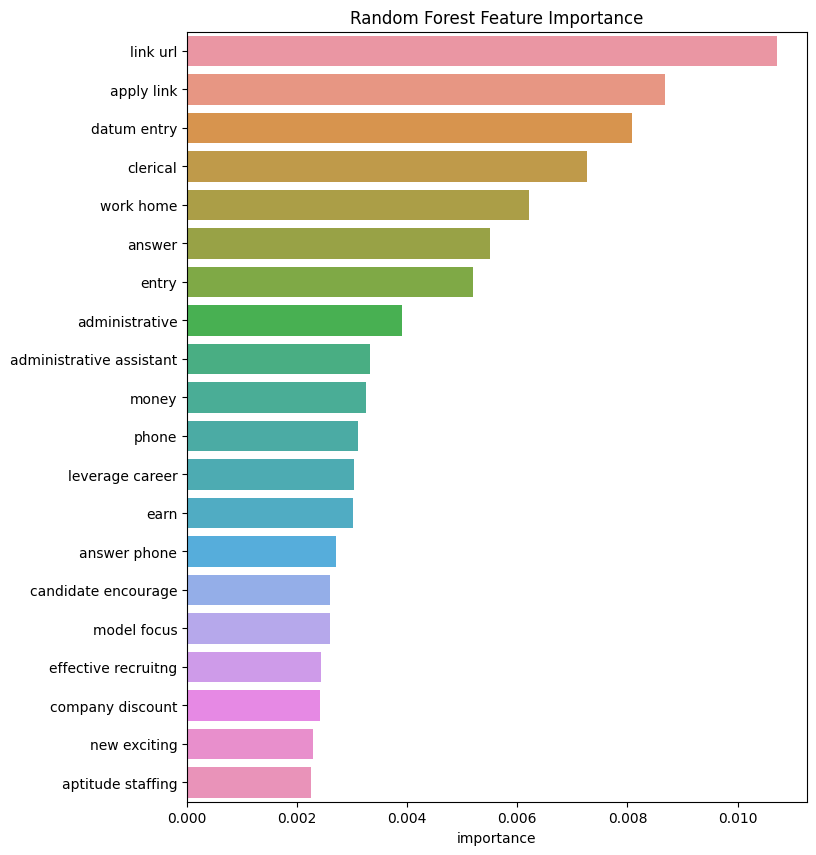

In [ ]:
feature_importance = model_rf.feature_importances_
original_feature_importance = data_pipeline.named_steps["selector"].inverse_transform(feature_importance.reshape(1, -1))
fi = pd.DataFrame(data=original_feature_importance.reshape(-1,1),
              index=data_pipeline.named_steps["vectorizer"].get_feature_names_out(),
              columns=['importance'])

fi_select = fi.sort_values('importance', ascending = False)[:20]
fig = plt.figure(figsize =(8, 10))
sns.barplot(x = fi_select.importance, y = fi_select.index ,
            ).set(title='Random Forest Feature Importance', ylabel = "")

In [ ]:
feature_indices = data_pipeline.named_steps["selector"].transform(np.array(data_pipeline.named_steps["vectorizer"].get_feature_names_out()).reshape(1, -1))[0]
print(feature_indices)

['100k' '100k management' '100k time' ... 'zigbee radio' 'zip' 'zip code']


In [ ]:
# columns_names = list(data_pipeline.named_steps["selector"].get_feature_names_out(data_pipeline.named_steps["vectorizer"].get_feature_names_out()))
# df = pd.DataFrame(X_test_p.todense(), columns=columns_names)

## Error analysis

In [ ]:
y_test_pred = model_rf.predict(X_test_p)
y_test_proba = model_rf.predict_proba(X_test_p)
y_test_wrong = pd.DataFrame(y_test[y_test_pred != y_test])
y_test_proba_wrong = y_test_proba[y_test_pred != y_test]
y_test_wrong['prob'] = y_test_proba_wrong[:,1]
y_test_wrong = y_test_wrong.sort_values(by=['prob'])
print(y_test_wrong)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


       fraudulent     prob
10306           1  0.00500
6244            1  0.00500
4983            1  0.00625
2123            1  0.01500
10360           1  0.01625
10365           1  0.03125
4583            1  0.04000
7076            1  0.04750
2090            1  0.05625
6069            1  0.05750
2936            1  0.05750
3920            1  0.06750
3593            1  0.11375
1657            1  0.11625
1675            1  0.12875
10260           1  0.13000
10309           1  0.13250
4148            1  0.15000
4077            1  0.15375
10343           1  0.16375
3171            1  0.23375
2851            1  0.24000
4698            1  0.24750
3444            1  0.27250
3087            1  0.29375
10369           1  0.30875
10231           1  0.33750
3919            1  0.38500
10348           1  0.40875
10182           1  0.41375
10229           1  0.43250
10234           1  0.48875
2080            1  0.49000
6874            0  0.53875
3865            0  0.62125
3836            0  0.62625
